## Kerasによる銀河形態分類（2クラス）畳み込みニューラルネット  
### Chollet, F. (2018). *Deep Learning with Python.* Manning Publications Co. Chapter 5参照

In [1]:
import os, shutil
import sys, time
import keras
keras.__version__

# 作業用ディレクトリ定義（要カスタマイズ）
galaxy_data_directory = '/home/satoshi/Galaxy/'

/home/satoshi/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### データセットの準備

In [2]:
elliptical_directory = galaxy_data_directory + 'elliptical'
spiral_directory = galaxy_data_directory + 'spiral'

train_dir = galaxy_data_directory + 'train'
os.mkdir(train_dir)
validation_dir = galaxy_data_directory + 'validation'
os.mkdir(validation_dir)
test_dir = galaxy_data_directory + 'test'
os.mkdir(test_dir)

train_elliptical_dir = train_dir + '/elliptical'
os.mkdir(train_elliptical_dir)
train_spiral_dir = train_dir + '/spiral'
os.mkdir(train_spiral_dir)

validation_elliptical_dir = validation_dir + '/elliptical'
os.mkdir(validation_elliptical_dir)
validation_spiral_dir = validation_dir + '/spiral'
os.mkdir(validation_spiral_dir)

test_elliptical_dir = test_dir + '/elliptical'
os.mkdir(test_elliptical_dir)
test_spiral_dir = test_dir + '/spiral'
os.mkdir(test_spiral_dir)

# 楕円銀河訓練データセット：　2000件
train_elliptical_fnames = [fname for fname in os.listdir(elliptical_directory )][:2000]
for fname in train_elliptical_fnames:
    src = os.path.join(elliptical_directory, fname)
    dst = os.path.join(train_elliptical_dir, fname)
    shutil.copyfile(src, dst)
# 楕円銀河検証データセット：　1000件
validation_elliptical_fnames = [fname for fname in os.listdir(elliptical_directory )][2000:3000]
for fname in validation_elliptical_fnames:
    src = os.path.join(elliptical_directory, fname)
    dst = os.path.join(validation_elliptical_dir, fname)
    shutil.copyfile(src, dst)
# 楕円銀河テストデータセット：　1000件    
test_elliptical_fnames = [fname for fname in os.listdir(elliptical_directory )][3000:4000]
for fname in test_elliptical_fnames:
    src = os.path.join(elliptical_directory, fname)
    dst = os.path.join(test_elliptical_dir, fname)
    shutil.copyfile(src, dst)

# 渦巻銀河訓練データセット：　2000件    
train_spiral_fnames = [fname for fname in os.listdir(spiral_directory)][:2000]
for fname in train_spiral_fnames:
    src = os.path.join(spiral_directory, fname)
    dst = os.path.join(train_spiral_dir, fname)
    shutil.copyfile(src, dst)
# 渦巻銀河検証データセット：　1000件
validation_spiral_fnames = [fname for fname in os.listdir(spiral_directory)][2000:3000]
for fname in validation_spiral_fnames:
    src = os.path.join(spiral_directory, fname)
    dst = os.path.join(validation_spiral_dir, fname)
    shutil.copyfile(src, dst)
# 渦巻銀河テストデータセット：　1000件    
test_spiral_fnames = [fname for fname in os.listdir(spiral_directory)][3000:4000]
for fname in test_spiral_fnames:
    src = os.path.join(spiral_directory, fname)
    dst = os.path.join(test_spiral_dir, fname)
    shutil.copyfile(src, dst)

#### Keras Conv2Dモデル  

In [3]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)       147584    
__________

#### モデルのコンパイル

In [4]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
        optimizer=optimizers.RMSprop(lr=1e-4),
        metrics=['acc'])

#### イメージデータジェネレータ

In [5]:
from keras.preprocessing.image import ImageDataGenerator

# イメージデータのスケール変換
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
# 訓練データジェネレータ　バッチサイズ：　20
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        batch_size=20,
        class_mode='binary')
# 検証データジェネレータ　バッチサイズ：　20
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        batch_size=20,
        class_mode='binary')
# テストデータジェネレータ　バッチサイズ：　20
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        batch_size=20,
        class_mode='binary')

Found 4000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


#### モデルの学習

In [6]:
# 学習　エポック数：　30
history = model.fit_generator(
        train_generator,
        steps_per_epoch=200,
        epochs=30,
        # 検証
        validation_data=validation_generator,
        validation_steps=100)

Epoch 1/30
200/200 [==============================] - 16s 78ms/step - loss: 0.1864 - acc: 0.9267 - val_loss: 0.0971 - val_acc: 0.9670
Epoch 2/30
200/200 [==============================] - 7s 35ms/step - loss: 0.1186 - acc: 0.9595 - val_loss: 0.0876 - val_acc: 0.9680
Epoch 3/30
200/200 [==============================] - 7s 36ms/step - loss: 0.1073 - acc: 0.9665 - val_loss: 0.1144 - val_acc: 0.9605
Epoch 4/30
200/200 [==============================] - 7s 36ms/step - loss: 0.1041 - acc: 0.9667 - val_loss: 0.3536 - val_acc: 0.8630
Epoch 5/30
200/200 [==============================] - 7s 35ms/step - loss: 0.1028 - acc: 0.9675 - val_loss: 0.0840 - val_acc: 0.9710
Epoch 6/30
200/200 [==============================] - 7s 35ms/step - loss: 0.0972 - acc: 0.9690 - val_loss: 0.0829 - val_acc: 0.9705
Epoch 7/30
200/200 [==============================] - 7s 36ms/step - loss: 0.0948 - acc: 0.9705 - val_loss: 0.0755 - val_acc: 0.9755
Epoch 8/30
200/200 [==============================] - 7s 36ms/step -

In [7]:
# モデルの退避
model.save(galaxy_data_directory + 'galaxy_model.h5')

#### 学習履歴のビジュアル化

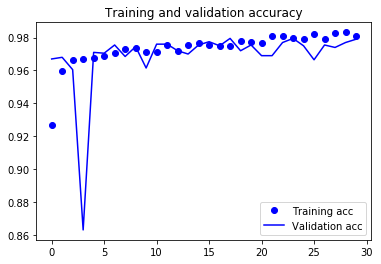

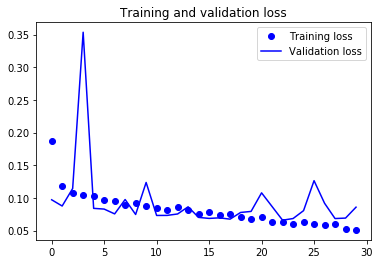

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### テストデータセットによる精度評価

In [9]:
metric = model.evaluate_generator(test_generator)
print('Test loss = ', metric[0])
print('Test acc  = ', metric[1])

Test loss =  0.05891254930873401
Test acc  =  0.980999995470047
